In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
# from imutils import paths
import cv2
import os
import torch_directml
from sklearn.model_selection import train_test_split, KFold
from torchsummary import summary
# from skorch import NeuralNetRegressor

In [2]:
mh_dataset_path = './../datasets/mhds_m/'
mh_image_paths = sorted(list(map(lambda x: os.path.join(mh_dataset_path,x), filter(lambda x: x not in ['', '.DS_Store'], os.listdir(mh_dataset_path)))))

c_dataset_path = './../datasets/cgds_m/'
c_image_paths = sorted(list(map(lambda x: os.path.join(c_dataset_path,x), filter(lambda x: x not in ['', '.DS_Store'], os.listdir(c_dataset_path)))))

TEST_SPLIT_MH = 0.02
TEST_SPLIT_C = 0.1
BATCH_SIZE = 64
INPUT_IMAGE_HEIGHT = 70
INPUT_IMAGE_WIDTH = 210 

dml = torch_directml.device()
device = dml

def itr_merge(*itrs):
    for itr in itrs:
        yield from itr

In [3]:
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

class EyeDataset(Dataset):
	def __init__(self, imagePaths, MH, transforms=None, bw=False):
		self.imagePaths = imagePaths
		self.images = []
		self.transforms = transforms
		for idx, imagePath in enumerate(self.imagePaths):
			# load the image from disk, swap its channels from BGR to RGB,
			# and read the associated mask from disk in grayscale mode
			image = cv2.imread(imagePath)
			if bw:
				image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			res = imagePath.split('/')[-1].split('.jpg')[0].split('_')
			if MH:
				pitch = -float(res[2][:-1])
				yaw = -float(res[3][:-1])
			else:
				pitch = float(res[2][:-1])
				yaw = float(res[3][:-1])
			hp = res[4]
			hr = res[5]
			hy = res[6]
			head_pos = torch.tensor([float(hp), float(hr), float(hy)], dtype=torch.float32)
			res = [float(pitch), float(yaw)]
			res = torch.tensor(res, dtype=torch.float32)
			# check to see if we are applying any transformations
			if self.transforms is not None:
				image = self.transforms(image)

			self.images.append(((image, head_pos), res))
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.images)
	def __getitem__(self, idx):
		return ((self.images[idx][0][0].to(device), self.images[idx][0][1].to(device)), self.images[idx][1].to(device))


In [4]:
(mainImagesMH, testImagesMH) = train_test_split(mh_image_paths, test_size=TEST_SPLIT_MH, random_state=42)
(trainImagesMH, valImagesMH) = train_test_split(mainImagesMH, test_size=TEST_SPLIT_MH, random_state=42)

# create the train and test datasets
trainDSMH = EyeDataset(imagePaths=trainImagesMH, transforms=transforms, MH=True)
valDSMH = EyeDataset(imagePaths=valImagesMH, transforms=transforms, MH=True)
testDSMH = EyeDataset(imagePaths=testImagesMH, transforms=transforms, MH=True)

# sklearn dataset
# ds = EyeDataset(imagePaths=imagePaths, transforms=transforms)
# X, y = list(map(lambda x: x[0], ds)), list(map(lambda x: x[1], ds))

print(f"[INFO] found {len(trainDSMH)} examples in MetaHuman the training set...")
print(f"[INFO] found {len(valDSMH)} examples in MetaHuman the validation set...")
print(f"[INFO] found {len(testDSMH)} examples in MetaHuman the test set...")

# create the training and test data loaders
trainLoaderMH = DataLoader(trainDSMH, shuffle=False,
	batch_size=BATCH_SIZE, num_workers=0)
valLoaderMH = DataLoader(valDSMH, shuffle=False,
	batch_size=1, num_workers=0)
testLoaderMH = DataLoader(testDSMH, shuffle=False,
	batch_size=1, num_workers=0)

[INFO] found 55085 examples in MetaHuman the training set...
[INFO] found 1125 examples in MetaHuman the validation set...
[INFO] found 1148 examples in MetaHuman the test set...


In [5]:

(mainImagesC, testImagesC) = train_test_split(c_image_paths, test_size=TEST_SPLIT_C, random_state=42)
(trainImagesC, valImagesC) = train_test_split(mainImagesC, test_size=TEST_SPLIT_C, random_state=42)

# create the train and test datasets
trainDSC = EyeDataset(imagePaths=trainImagesC, transforms=transforms, MH=False)
valDSC = EyeDataset(imagePaths=valImagesC, transforms=transforms, MH=False)
testDSC = EyeDataset(imagePaths=testImagesC, transforms=transforms, MH=False)

print(f"[INFO] found {len(trainDSC)} examples in Columbia the training set...")
print(f"[INFO] found {len(valDSC)} examples in Columbia the validation set...")
print(f"[INFO] found {len(testDSC)} examples in Columbia the test set...")

# create the training and test data loaders
trainLoaderC = DataLoader(trainDSC, shuffle=False,
	batch_size=BATCH_SIZE, num_workers=0)
valLoaderC = DataLoader(valDSC, shuffle=False,
	batch_size=1, num_workers=0)
testLoaderC = DataLoader(testDSC, shuffle=False,
	batch_size=1, num_workers=0)

[INFO] found 9525 examples in Columbia the training set...
[INFO] found 1059 examples in Columbia the validation set...
[INFO] found 1176 examples in Columbia the test set...


In [6]:

trainLoader = DataLoader(ConcatDataset([trainDSC, trainDSMH]), shuffle=True,
	batch_size=BATCH_SIZE, num_workers=0)
valLoader = DataLoader(ConcatDataset([valDSC, testDSC]), shuffle=True,
	batch_size=1, num_workers=0)
testLoader = DataLoader(ConcatDataset([testDSC, testDSMH]), shuffle=True,
	batch_size=1, num_workers=0)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [7]:
class FourthEyeNet(nn.ModuleList):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(9, 26, 3)
        self.fc1 = nn.Linear(3432, 600)
        self.fc2 = nn.Linear(603, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x, head_pos = x
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.cat((x, head_pos), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SixthEyeNet(nn.ModuleList):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(9, 26, 3)
        self.fc1 = nn.Linear(3432, 600)
        self.fc2 = nn.Linear(600, 50)
        self.fc3 = nn.Linear(53, 2)

    def forward(self, x):
        x, head_pos = x
        head_pos = head_pos
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cat((x, head_pos), 1)
        x = self.fc3(x)
        return x

class ForthEyeNetNoHeadPose(nn.ModuleList):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(9, 26, 3)
        self.fc1 = nn.Linear(3432, 600)
        self.fc2 = nn.Linear(600, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x, head_pos = x
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SeventhEyeNet(nn.ModuleList):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 9, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(9, 26, 3)
        self.fc1 = nn.Linear(3432, 600)
        self.fc2 = nn.Linear(600, 50)
        self.fc3 = nn.Linear(53, 2)

    def forward(self, x):
        x, head_pos = x
        head_pos = head_pos
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cat((x, head_pos), 1)
        x = self.fc3(x)
        return x


def create_network():
    # net = ForthEyeNetNoHeadPose()
    # net = FourthEyeNet()
    net = SixthEyeNet()
    # net = SeventhEyeNet()
    net.to(device)

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    return net, criterion, optimizer

net, criterion, optimizer = create_network()
# summary(net, (3, 70, 210))

In [8]:
changed = False
changed2 = False
every = 200
training_epoch_loss = []
validation_epoch_loss = []
for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics

        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % every == every - 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / every:.3f}')
            # if running_loss / every < 2 and not changed: 
            #     changed = True
            #     for g in optimizer.param_groups:
            #         g['lr'] *= 0.1
            # if running_loss / every < 0.5 and not changed2: 
            #     changed2 = True
            #     for g in optimizer.param_groups:
            #         g['lr'] *= 0.1
            running_loss = 0.0
    losses = []
    criterion2 = nn.L1Loss().to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            losses.append(criterion2(outputs, labels).item())
    training_epoch_loss.append(epoch_loss/len(trainLoader))
    validation_epoch_loss.append(sum(losses)/len(losses))
    print(f'Accuracy of the network on the validation images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')

print('Finished Training')

[1,   200] loss: 112.646
[1,   400] loss: 48.436
[1,   600] loss: 28.578
[1,   800] loss: 19.450
[1,  1000] loss: 15.710
Accuracy of the network on the validation images: 23.625102996826172, 0.07238567620515823, 4.906829969778291
[2,   200] loss: 12.398
[2,   400] loss: 10.824
[2,   600] loss: 10.057
[2,   800] loss: 8.985
[2,  1000] loss: 7.775
Accuracy of the network on the validation images: 21.27880096435547, 0.051842689514160156, 3.940284813307142
[3,   200] loss: 6.985
[3,   400] loss: 6.547
[3,   600] loss: 6.125
[3,   800] loss: 6.210
[3,  1000] loss: 5.475
Accuracy of the network on the validation images: 19.313148498535156, 0.01864147186279297, 3.4048072116020274
[4,   200] loss: 5.038
[4,   400] loss: 4.720
[4,   600] loss: 4.856
[4,   800] loss: 4.561
[4,  1000] loss: 4.355
Accuracy of the network on the validation images: 15.988645553588867, 0.04880864918231964, 3.1311908928873287
[5,   200] loss: 3.704
[5,   400] loss: 3.893
[5,   600] loss: 3.710
[5,   800] loss: 3.690
[

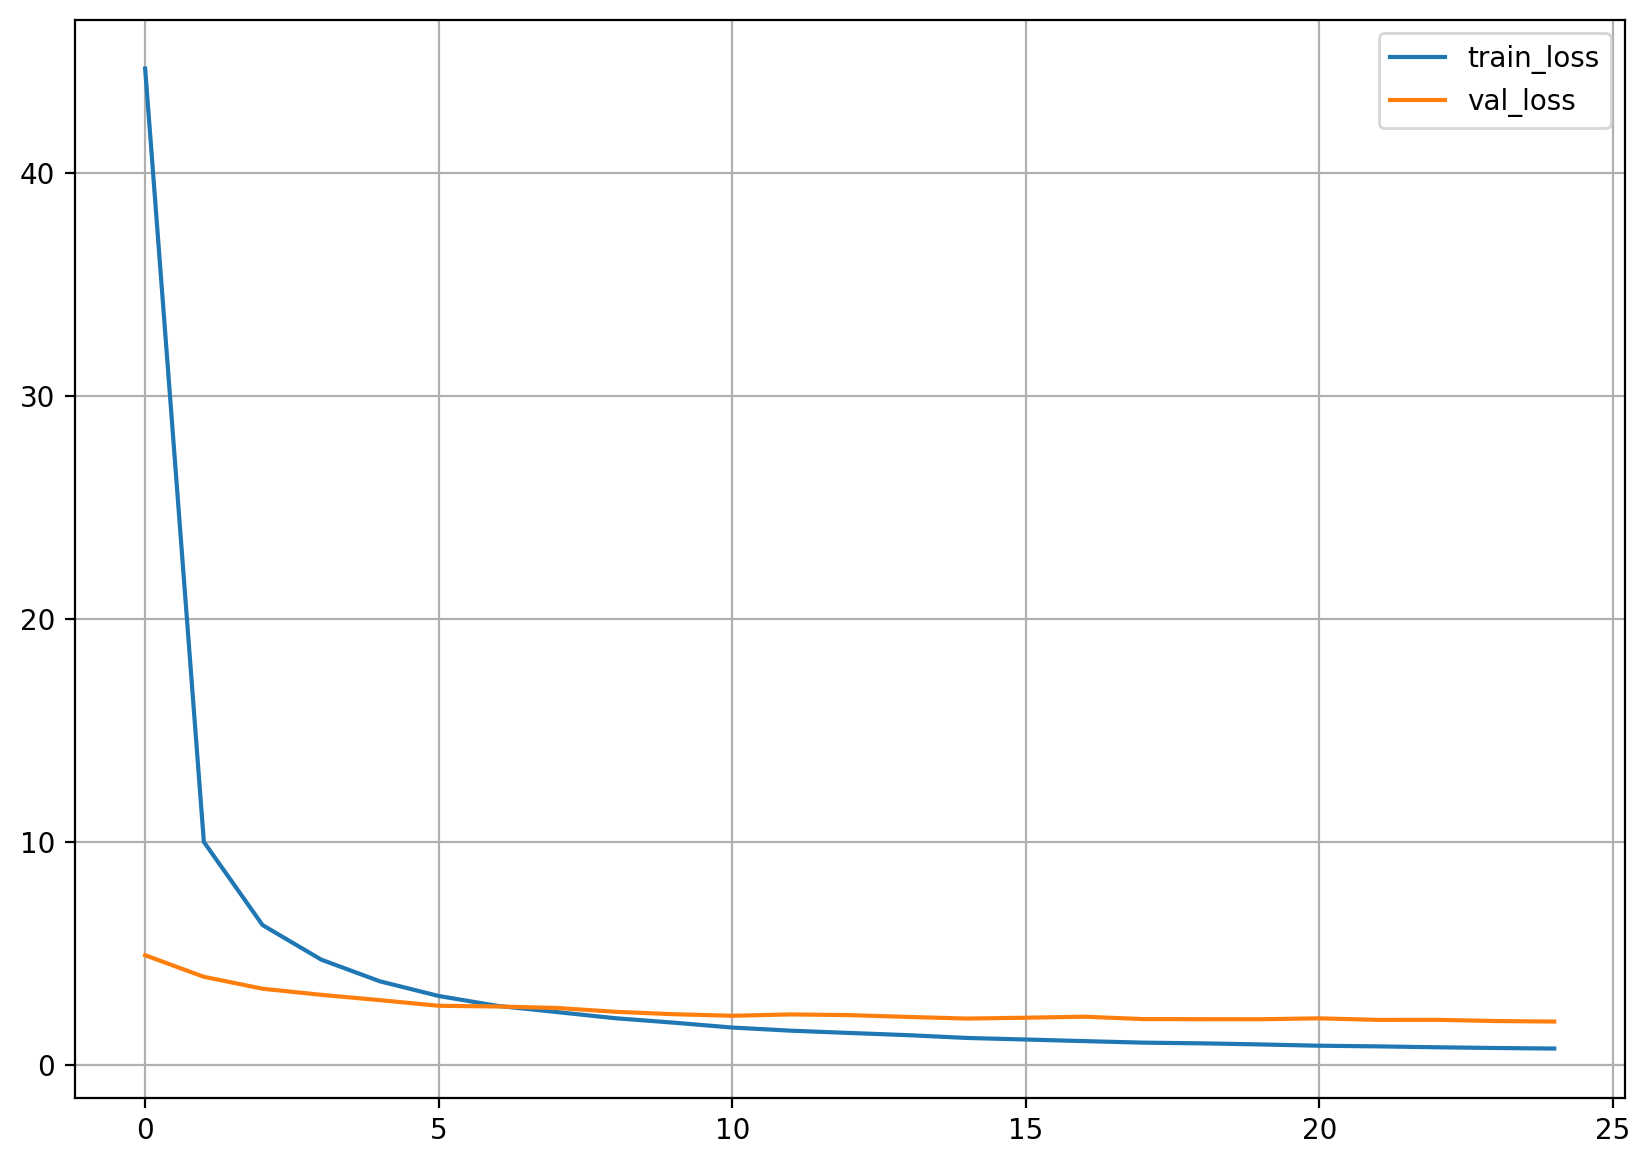

In [9]:
def plot_train_val_loss(training_losses, validation_losses):
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.plot(training_losses, label='train_loss')
    plt.plot(validation_losses, label='val_loss')
    plt.legend()
    plt.show()

plot_train_val_loss(training_epoch_loss, validation_epoch_loss)

In [12]:
net, criterion, optimizer = create_network()

In [ ]:
every = 50
training_epoch_loss = []
validation_epoch_loss = []
for epoch in range(120):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainLoaderC, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics

        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % every == every - 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / every:.3f}')
            running_loss = 0.0
    losses = []
    with torch.no_grad():
        for data in valLoaderC:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            losses.append(criterion(outputs, labels).item())
    training_epoch_loss.append(epoch_loss/len(trainLoaderC))
    validation_epoch_loss.append(sum(losses)/len(losses))
    print(f'Accuracy of the network on the validation images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')

print('Finished Training')

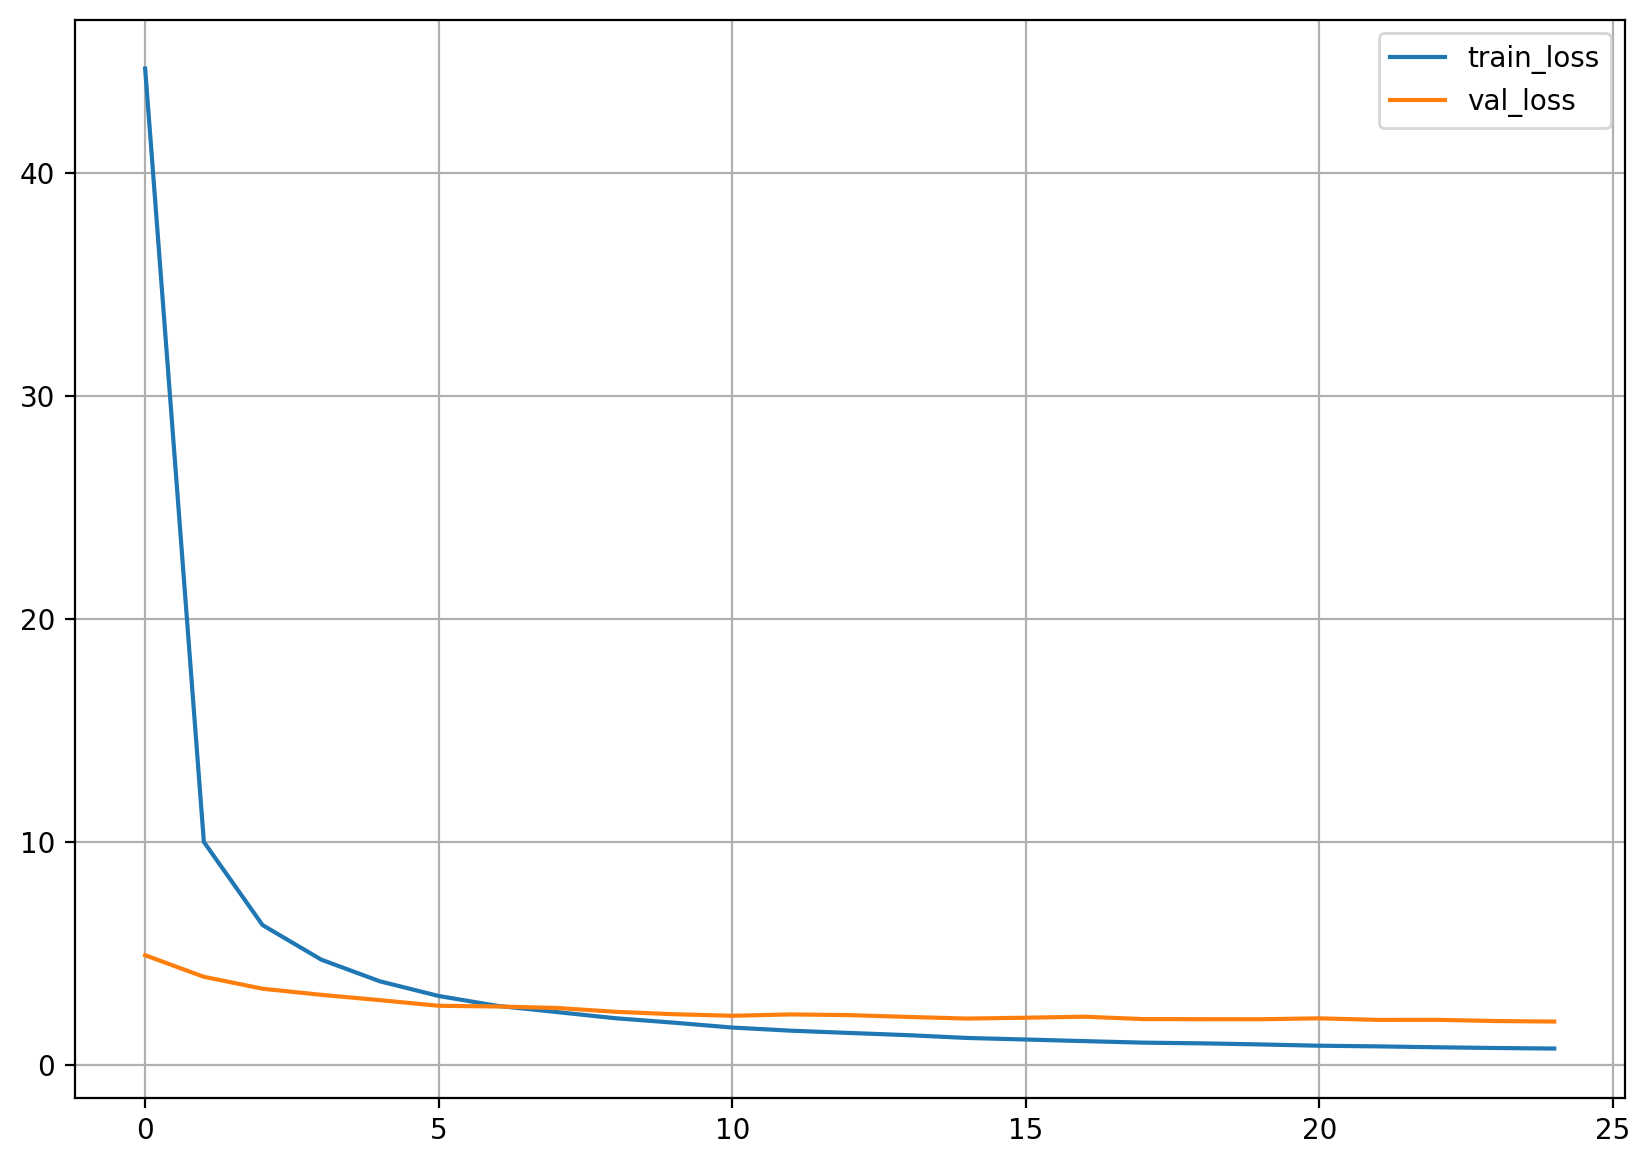

In [10]:
plot_train_val_loss(training_epoch_loss, validation_epoch_loss)

In [11]:
PATH = './models/sixth_eye_net_combined.pth'
net.to('cpu')
torch.save(net.state_dict(), PATH)

In [35]:
net.load_state_dict(torch.load(PATH))
net.to(dml)

ForthEyeNet(
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 26, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3432, out_features=600, bias=True)
  (fc2): Linear(in_features=603, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [19]:
losses = []
criterion2 = nn.L1Loss().to(device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoaderMH:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        losses.append(criterion2(outputs, labels))

        
print(f'Accuracy of the network on the test images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')
# Accuracy of the network on the test images: 11.710856437683105, 0.05646705627441406, 1.7454159259796143

Accuracy of the network on the test images: 41.53703308105469, 1.272262454032898, 18.952001571655273


In [6]:
del trainDSC
del trainLoaderC
del trainDSMH
del trainLoaderMH

NameError: name 'trainDSMH' is not defined

In [5]:
fullDSMH = EyeDataset(imagePaths=mh_image_paths, transforms=transforms, MH=True)

In [9]:
# Cross-validation Metahuman dataset

# sourcery skip: for-index-underscore
every = 50
k_folds = 4
results = []
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)


for fold, (train_ids, test_ids) in enumerate(kfold.split(fullDSMH)):
    print(f'FOLD {fold}')
    net, criterion, optimizer = create_network()

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainLoader = DataLoader(fullDSMH, shuffle=False,
        batch_size=BATCH_SIZE, num_workers=0, sampler=train_subsampler)
    testLoader = DataLoader(fullDSMH, shuffle=False,
        batch_size=1, num_workers=0, sampler=test_subsampler)
        
    for epoch in range(25):  # loop over the dataset multiple times
        epoch_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics

            epoch_loss += loss.item()
        print(f'Epoch {epoch:02d} | Loss: {epoch_loss/len(trainLoader):.4f}')
    losses = []
    criterion2 = nn.L1Loss().to(device)
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            losses.append(criterion2(outputs, labels).item())
    print(f'Accuracy of the network on the test images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')
    results.append(sum(losses)/len(losses))
    path = f'./models/kfold/fold{fold}_MH.pth'
    torch.save(net.to('cpu').state_dict(), path)

print('Finished Training')

FOLD 0
Epoch 00 | Loss: 67.8588
Epoch 01 | Loss: 18.0702
Epoch 02 | Loss: 10.4328
Epoch 03 | Loss: 7.2706
Epoch 04 | Loss: 5.3678
Epoch 05 | Loss: 4.2786
Epoch 06 | Loss: 3.6377
Epoch 07 | Loss: 3.0515
Epoch 08 | Loss: 2.6960
Epoch 09 | Loss: 2.5049
Epoch 10 | Loss: 2.2065
Epoch 11 | Loss: 1.9802
Epoch 12 | Loss: 1.8344
Epoch 13 | Loss: 1.6840
Epoch 14 | Loss: 1.5862
Epoch 15 | Loss: 1.4978
Epoch 16 | Loss: 1.4464
Epoch 17 | Loss: 1.2972
Epoch 18 | Loss: 1.2962
Epoch 19 | Loss: 1.1844
Epoch 20 | Loss: 1.1362
Epoch 21 | Loss: 1.1603
Epoch 22 | Loss: 1.0841
Epoch 23 | Loss: 0.9925
Epoch 24 | Loss: 0.9810
Accuracy of the network on the test images: 11.021512031555176, 0.010988473892211914, 0.8384669456906315
FOLD 1
Epoch 00 | Loss: 71.8247
Epoch 01 | Loss: 15.5117
Epoch 02 | Loss: 8.2546
Epoch 03 | Loss: 5.9908
Epoch 04 | Loss: 4.3972
Epoch 05 | Loss: 3.5557
Epoch 06 | Loss: 3.0620
Epoch 07 | Loss: 2.6130
Epoch 08 | Loss: 2.3877
Epoch 09 | Loss: 2.0982
Epoch 10 | Loss: 1.9339
Epoch 11 | L

In [6]:
# del fullDSMH
fullDSC = EyeDataset(imagePaths=c_image_paths, transforms=transforms, MH=False, bw=False)

In [8]:
# Cross-validation Columbia dataset

# sourcery skip: for-index-underscore
every = 50
k_folds = 4
results = []
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)


for fold, (train_ids, test_ids) in enumerate(kfold.split(fullDSC)):
    print(f'FOLD {fold}')
    net, criterion, optimizer = create_network()

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainLoader = DataLoader(fullDSC, shuffle=False,
        batch_size=BATCH_SIZE, num_workers=0, sampler=train_subsampler)
    testLoader = DataLoader(fullDSC, shuffle=False,
        batch_size=1, num_workers=0, sampler=test_subsampler)
        
    for epoch in range(40):  # loop over the dataset multiple times
        epoch_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics

            epoch_loss += loss.item()
        print(f'Epoch {epoch:02d} | Loss: {epoch_loss/len(trainLoader):.4f}')
    losses = []
    criterion2 = nn.L1Loss().to(device)
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            losses.append(criterion2(outputs, labels).item())
    print(f'Accuracy of the network on the test images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')
    results.append(sum(losses)/len(losses))
    path = f'./models/kfold/fold{fold}_C.pth'
    torch.save(net.to('cpu').state_dict(), path)

print('Finished Training')

FOLD 0
Epoch 00 | Loss: 69.8889
Epoch 01 | Loss: 51.5163
Epoch 02 | Loss: 42.0528
Epoch 03 | Loss: 35.0328
Epoch 04 | Loss: 29.7365
Epoch 05 | Loss: 25.1133
Epoch 06 | Loss: 22.0319
Epoch 07 | Loss: 18.8409
Epoch 08 | Loss: 16.6815
Epoch 09 | Loss: 14.4168
Epoch 10 | Loss: 12.8344
Epoch 11 | Loss: 11.3331
Epoch 12 | Loss: 10.3790
Epoch 13 | Loss: 9.2608
Epoch 14 | Loss: 8.5661
Epoch 15 | Loss: 7.6878
Epoch 16 | Loss: 7.1292
Epoch 17 | Loss: 6.2936
Epoch 18 | Loss: 5.7806
Epoch 19 | Loss: 5.2624
Epoch 20 | Loss: 4.7519
Epoch 21 | Loss: 4.5251
Epoch 22 | Loss: 4.0718
Epoch 23 | Loss: 3.7313
Epoch 24 | Loss: 3.4376
Epoch 25 | Loss: 3.0749
Epoch 26 | Loss: 2.8722
Epoch 27 | Loss: 2.7284
Epoch 28 | Loss: 2.5319
Epoch 29 | Loss: 2.2684
Epoch 30 | Loss: 2.0470
Epoch 31 | Loss: 2.0202
Epoch 32 | Loss: 1.9061
Epoch 33 | Loss: 1.7429
Epoch 34 | Loss: 1.7024
Epoch 35 | Loss: 1.4712
Epoch 36 | Loss: 1.5210
Epoch 37 | Loss: 1.3998
Epoch 38 | Loss: 1.3505
Epoch 39 | Loss: 1.3116
Accuracy of the netw

In [7]:
# Cross-validation of all datasets

def train_model(criterion, optimizer, trainLoaders: list, network, epochs, printEpochs=False):
    for epoch in range(40):  # loop over the dataset multiple times
        epoch_loss = 0.0
        for i, data in enumerate(itr_merge(*trainLoaders), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics

            epoch_loss += loss.item()
        if printEpochs:
            print(f'Epoch {epoch:02d} | Loss: {epoch_loss/sum(map(lambda x: len(x), trainLoaders)):.4f}')

def test_model(network, testLoader, model_str, dataset_str):
    losses = []
    criterion2 = nn.L1Loss().to(device)
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = network(images)
            losses.append(criterion2(outputs, labels).item())
    print(f'Accuracy of the network trained on {model_str} on the test images from {dataset_str} dataset: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}, std: {np.std(losses)}')
    return (sum(losses)/len(losses))


every = 50
k_folds = 4
results = []
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

c_folds = list(kfold.split(fullDSC))
mh_folds = list(kfold.split(fullDSMH))


for fold in range(k_folds):
    print(f'FOLD {fold}')
    net_mh, criterion_mh, optimizer_mh = create_network()

    train_subsampler_mh = torch.utils.data.SubsetRandomSampler(mh_folds[fold][0])
    test_subsampler_mh = torch.utils.data.SubsetRandomSampler(mh_folds[fold][1])

    trainLoader_mh = DataLoader(fullDSMH, shuffle=False,
        batch_size=BATCH_SIZE, num_workers=0, sampler=train_subsampler_mh)
    testLoader_mh = DataLoader(fullDSMH, shuffle=False,
        batch_size=1, num_workers=0, sampler=test_subsampler_mh)

    train_model(criterion_mh, optimizer_mh, [trainLoader_mh], net_mh, 25)

    net_c, criterion_c, optimizer_c = create_network()

    train_subsampler_c = torch.utils.data.SubsetRandomSampler(c_folds[fold][0])
    test_subsampler_c = torch.utils.data.SubsetRandomSampler(c_folds[fold][1])

    trainLoader_c = DataLoader(fullDSC, shuffle=False,
        batch_size=BATCH_SIZE, num_workers=0, sampler=train_subsampler_c)
    testLoader_c = DataLoader(fullDSC, shuffle=False,
        batch_size=1, num_workers=0, sampler=test_subsampler_c)
    
        
    train_model(criterion_c, optimizer_c, [trainLoader_c], net_c, 40)

    net_f, criterion_f, optimizer_f = create_network()

    testLoader_f = itr_merge(testLoader_c, testLoader_mh)
        
    train_model(criterion_f, optimizer_f, [trainLoader_c, trainLoader_mh], net_f, 25)


    test_model(net_mh, testLoader_mh, 'MH', 'MH')
    test_model(net_mh, testLoader_c, 'MH', 'C')
    test_model(net_mh, testLoader_f, 'MH', 'F')

    testLoader_f = itr_merge(testLoader_c, testLoader_mh)

    test_model(net_c, testLoader_mh, 'C', 'MH')
    test_model(net_c, testLoader_c, 'C', 'C')
    test_model(net_c, testLoader_f, 'C', 'F')

    testLoader_f = itr_merge(testLoader_c, testLoader_mh)

    test_model(net_f, testLoader_mh, 'F', 'MH')
    test_model(net_f, testLoader_c, 'F', 'C')
    test_model(net_f, testLoader_f, 'F', 'F')
    PATH = f'./models/kfold/fold{fold}_F.pth'
    net_f.to('cpu')
    torch.save(net_f.state_dict(), PATH)

print('Finished Training')

FOLD 0
Accuracy of the network trained on MH on the test images from MH dataset: 11.177326202392578, 0.0031833648681640625, 0.7871533127906869, std: 0.5952205405669176
Accuracy of the network trained on MH on the test images from C dataset: 44.40381622314453, 0.24726176261901855, 8.365261389913202, std: 5.865249096952682
Accuracy of the network trained on MH on the test images from F dataset: 44.40381622314453, 0.0031833648681640625, 2.0764842009122257, std: 3.7756187588056873
Accuracy of the network trained on C on the test images from MH dataset: 29.965320587158203, 0.014342904090881348, 8.551229291179606, std: 4.8942316499689005
Accuracy of the network trained on C on the test images from C dataset: 22.611480712890625, 0.025250673294067383, 1.9903342125962684, std: 1.5752791164887692
Accuracy of the network trained on C on the test images from F dataset: 29.965320587158203, 0.014342904090881348, 7.434965892392857, std: 5.135944356221559
Accuracy of the network trained on F on the te